In [1]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import libraries

import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical computations and array operations
import matplotlib.pyplot as plt  # Data visualization
import seaborn as sns  # Statistical data visualization

from scipy.stats import norm  # Statistical functions (normal distribution)
from scipy import stats  # Statistical functions and tests
%matplotlib inline

from sklearn import metrics  # Model evaluation metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # Feature scaling and encoding
from sklearn.cluster import KMeans  # Clustering algorithm
from sklearn.preprocessing import MinMaxScaler  # Feature scaling (normalization)

from matplotlib.colors import ListedColormap  # Custom color mapping for plots

# Model selection, cross-validation, and hyperparameter tuning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

# Performance evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Machine learning models
from sklearn.linear_model import LogisticRegression  # Logistic Regression (classification)
from sklearn.neighbors import KNeighborsClassifier  # k-Nearest Neighbors classifier
from sklearn.tree import DecisionTreeClassifier  # Decision Tree classifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # Ensemble learning models

from sklearn.metrics import classification_report  # Detailed classification metrics report

import xgboost as xgb  # XGBoost model (gradient boosting)
import lightgbm as lgb  # LightGBM model (gradient boosting)

import ast  # Handling abstract syntax trees (useful for parsing)
import pickle  # Saving and loading Python objects (e.g., trained models)

from imblearn.over_sampling import SMOTE  # Synthetic Minority Over-sampling Technique (handles class imbalance)
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output


In [3]:
# load the data
df = pd.read_csv(r"C:\Users\manod\Desktop\Capstone\Data\Financial_risk_assesement_final.csv",)

# print the first 5 rows of the data
df.head()


,age_bucket,income_bucket,gender,occupation,education_level,marital_status,has_loan,risk_preference,reaction_to_loss,financial_knowledge_level,...,risk_preference_num,reaction_to_loss_num,financial_knowledge_num,saving_frequency,investment_frequency,has_insurance,financial_goal,time_horizon,risk_rating,risk_rating_num
0,45-54,">70,000",Male,Unemployed,PhD,Divorced,1,Low Risk,Hold and wait it out,Intermediate,...,0,1,2,Monthly,Rarely,Yes,Retirement,More than 10 years,Low,0
1,55-64,">70,000",Female,Employed,Bachelor's,Widowed,1,Low Risk,Invest more while prices are low,Intermediate,...,0,2,2,Monthly,Occasionally,No,Retirement,More than 10 years,Medium,1
2,18-24,"50,000–70,000",Non-binary,Employed,Master's,Single,1,Low Risk,Sell everything to avoid further losses,Beginner,...,0,0,1,Monthly,Occasionally,Yes,General wealth building,More than 10 years,Medium,1
3,55-64,"<30,000",Male,Unemployed,Bachelor's,Single,1,Low Risk,Invest more while prices are low,Advanced,...,0,2,3,Weekly,Rarely,Yes,Retirement,More than 10 years,Medium,1
4,25-34,"30,000–50,000",Non-binary,Unemployed,Bachelor's,Widowed,1,Low Risk,Sell everything to avoid further losses,Intermediate,...,0,0,2,Monthly,Occasionally,Yes,General wealth building,More than 10 years,Low,0


In [4]:
#Changing the type of columns to the most appropriate ones
#Convert appropriate columns to categorical
categorical_cols = ['gender', 'occupation', 'education_level', 'marital_status', 'loan_purpose','payment_history','financial_knowledge_level']
for col in categorical_cols:
    df[col] = df[col].astype('category')			

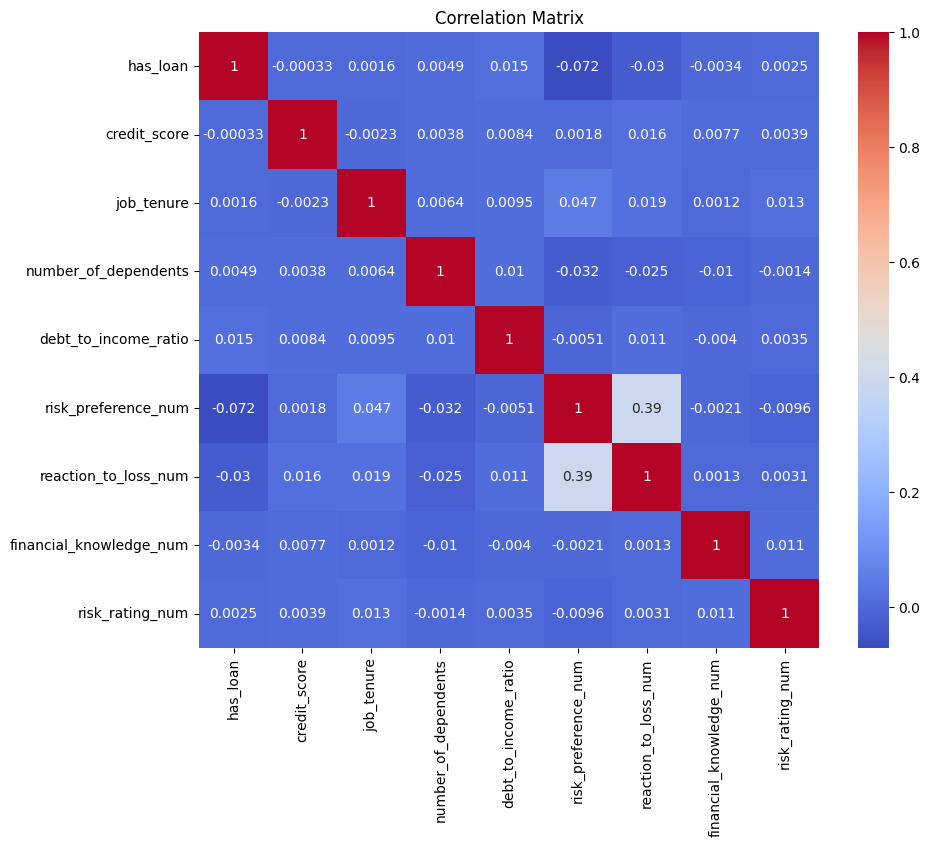

In [5]:
# Visualize correlation matrix for numeric features
# Select only numeric features for correlation calculation
numeric_df = df.select_dtypes(include=np.number)
plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [6]:
# Set the target variable
y = df['risk_rating_num']
print(y.value_counts()) # Check distribution of your target

risk_rating_num
0    9000
1    4500
2    1500
Name: count, dtype: int64


In [7]:
# Define features (X) - excluding the targets and their original string versions
# Include original features and your simulated behavioral features
X = df[[
    'age_bucket', 'income_bucket', 'gender', 'occupation', 'education_level',
    'marital_status', 'has_loan', 'credit_score', 'job_tenure',
    'number_of_dependents', 'loan_purpose', 'payment_history', 'debt_to_income_ratio',
    # Simulated behavioral features (as discussed, can be used as predictors for risk_rating_num)
    'reaction_to_loss', 'financial_knowledge_level', 'saving_frequency',
    'investment_frequency', 'has_insurance', 'financial_goal', 'time_horizon'
]]

print("Features selected for X:")
print(X.columns.tolist())

Features selected for X:
['age_bucket', 'income_bucket', 'gender', 'occupation', 'education_level', 'marital_status', 'has_loan', 'credit_score', 'job_tenure', 'number_of_dependents', 'loan_purpose', 'payment_history', 'debt_to_income_ratio', 'reaction_to_loss', 'financial_knowledge_level', 'saving_frequency', 'investment_frequency', 'has_insurance', 'financial_goal', 'time_horizon']


In [8]:
# Identify categorical and numerical columns in the new X
categorical_features = [
    'age_bucket', 'income_bucket', 'gender', 'occupation', 'education_level',
    'marital_status', 'loan_purpose', 'payment_history', 'reaction_to_loss',
    'financial_knowledge_level', 'saving_frequency', 'investment_frequency',
    'has_insurance', 'financial_goal', 'time_horizon'
]
numerical_features = [
    'has_loan', 'credit_score', 'job_tenure', 'number_of_dependents', 'debt_to_income_ratio'
]

# Ensure all columns exist in X
missing_cat_cols = [col for col in categorical_features if col not in X.columns]
missing_num_cols = [col for col in numerical_features if col not in X.columns]

if missing_cat_cols:
    print(f"Warning: Missing categorical columns in X: {missing_cat_cols}")
if missing_num_cols:
    print(f"Warning: Missing numerical columns in X: {missing_num_cols}")

# Convert categorical columns to 'category' dtype if not already done
for col in categorical_features:
    if col in X.columns:
        X[col] = X[col].astype('category')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   age_bucket                 15000 non-null  object  
 1   income_bucket              15000 non-null  object  
 2   gender                     15000 non-null  category
 3   occupation                 15000 non-null  category
 4   education_level            15000 non-null  category
 5   marital_status             15000 non-null  category
 6   has_loan                   15000 non-null  int64   
 7   risk_preference            15000 non-null  object  
 8   reaction_to_loss           15000 non-null  object  
 9   financial_knowledge_level  15000 non-null  category
 10  credit_score               15000 non-null  float64 
 11  job_tenure                 15000 non-null  int64   
 12  number_of_dependents       15000 non-null  float64 
 13  loan_purpose               1500

In [10]:
# Create new binary target column
df['risk_binary'] = df['risk_rating_num'].apply(lambda x: 0 if x == 0 else 1)

# Check distribution
print(df['risk_binary'].value_counts())

risk_binary
0    9000
1    6000
Name: count, dtype: int64


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,  # your full feature dataframe
    df['risk_binary'],  # the entire target series with both classes
    test_size=0.15,
    stratify=df['risk_binary'],  # stratify by the full target to keep class balance
    random_state=42
)

print("Train target distribution:\n", y_train.value_counts())
print("Test target distribution:\n", y_test.value_counts())


Train target distribution:
 risk_binary
0    7650
1    5100
Name: count, dtype: int64
Test target distribution:
 risk_binary
0    1350
1     900
Name: count, dtype: int64


In [12]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report
import xgboost as xgb
import lightgbm as lgb

# Assume X_train, X_test, y_train, y_test already defined with your existing split and target

# Define categorical and numerical features (adjust as needed)
categorical_features = [
    'age_bucket', 'income_bucket', 'gender', 'occupation', 'education_level',
    'marital_status', 'loan_purpose', 'payment_history', 'financial_knowledge_level',
    'saving_frequency', 'investment_frequency', 'has_insurance', 'financial_goal', 'time_horizon'
]
numerical_features = ['credit_score', 'job_tenure', 'number_of_dependents', 'debt_to_income_ratio']

# One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = encoder.fit_transform(X_train[categorical_features])
X_test_cat = encoder.transform(X_test[categorical_features])

# Scale numerical features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numerical_features])
X_test_num = scaler.transform(X_test[numerical_features])

# Combine features
X_train_processed = np.hstack([X_train_cat, X_train_num])
X_test_processed = np.hstack([X_test_cat, X_test_num])

# Balance training data with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

# Define classifiers
models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100),
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    #"SVM (RBF kernel)": SVC(class_weight='balanced', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42)
}

for model_name, model in models.items():
    print(f"\n--- Training and evaluating: {model_name} ---")
    model.fit(X_train_smote, y_train_smote)

    y_pred = model.predict(X_test_processed)
    print("Classification report with default threshold (0.5):")
    print(classification_report(y_test, y_pred, target_names=['Low Risk', 'Risk Taker']))

    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test_processed)[:, 1]
        thresholds = np.arange(0.1, 1.0, 0.1)
        print("Threshold | Precision | Recall | F1-Score")
        for t in thresholds:
            y_pred_thresh = (y_probs >= t).astype(int)
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_thresh, average='binary')
            print(f"{t:.2f}     | {precision:.3f}    | {recall:.3f} | {f1:.3f}")
    else:
        print("Model does not support predict_proba; skipping threshold tuning.")



--- Training and evaluating: Random Forest ---
Classification report with default threshold (0.5):
              precision    recall  f1-score   support

    Low Risk       0.60      0.87      0.71      1350
  Risk Taker       0.40      0.13      0.20       900

    accuracy                           0.57      2250
   macro avg       0.50      0.50      0.45      2250
weighted avg       0.52      0.57      0.51      2250

Threshold | Precision | Recall | F1-Score
0.10     | 0.400    | 1.000 | 0.571
0.20     | 0.400    | 1.000 | 0.571
0.30     | 0.397    | 0.941 | 0.559
0.40     | 0.401    | 0.662 | 0.500
0.50     | 0.406    | 0.161 | 0.231
0.60     | 0.360    | 0.010 | 0.019
0.70     | 0.000    | 0.000 | 0.000
0.80     | 0.000    | 0.000 | 0.000
0.90     | 0.000    | 0.000 | 0.000

--- Training and evaluating: Logistic Regression ---
Classification report with default threshold (0.5):
              precision    recall  f1-score   support

    Low Risk       0.61      0.51      0.55   

In [13]:
# After fitting the encoder (before model training), get full feature names

cat_feature_names = encoder.get_feature_names_out(categorical_features)
full_feature_names = list(cat_feature_names) + numerical_features


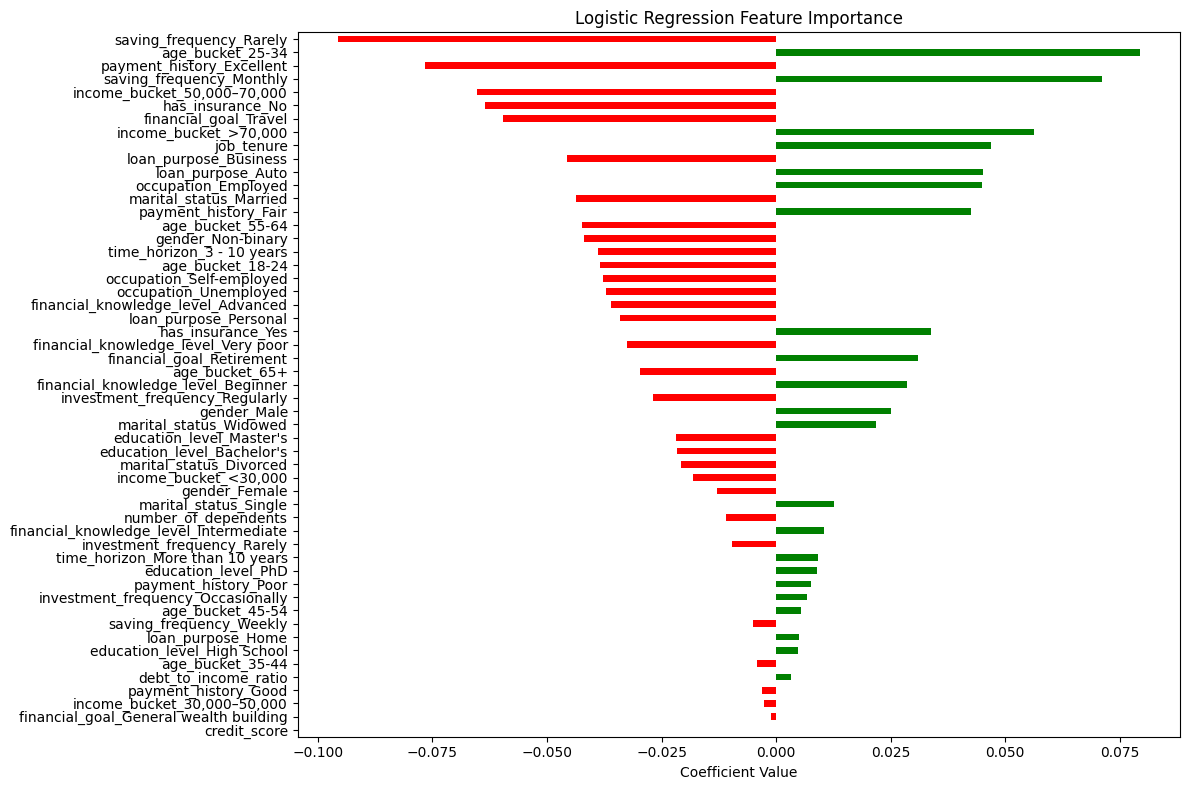

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature names from the encoder and scaler
encoded_cat_features = encoder.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([encoded_cat_features, numerical_features])

# Get the trained logistic regression model
logreg_model = models["Logistic Regression"]

# Get the coefficients and associate them with feature names
coefficients = logreg_model.coef_[0]
feat_imp = pd.Series(coefficients, index=all_feature_names).sort_values(key=abs, ascending=False)

# Plot
plt.figure(figsize=(12, 8))
colors = ['green' if val > 0 else 'red' for val in feat_imp]
feat_imp.plot(kind='barh', color=colors)
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


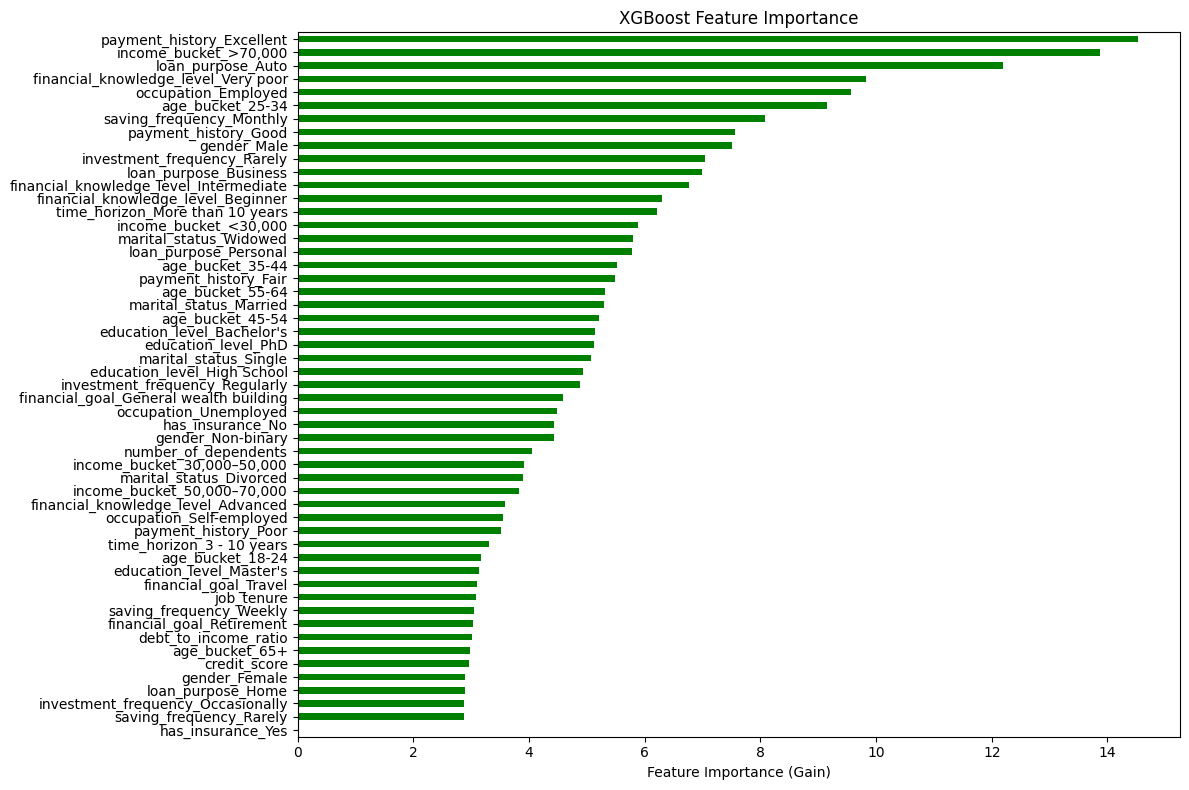

In [21]:


# Get feature names from encoder and numerical list
encoded_cat_features = encoder.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([encoded_cat_features, numerical_features])

# Get feature importance (by gain)
booster = models["XGBoost"].get_booster()
booster.feature_names = list(all_feature_names)

#booster.feature_names = all_feature_names  # Ensure proper mapping

# Get importance dictionary
importance_dict = booster.get_score(importance_type='gain')

# Create Series and fill missing features with 0 importance
feat_imp = pd.Series({name: importance_dict.get(name, 0.0) for name in all_feature_names})
feat_imp = feat_imp.sort_values(ascending=True)  # For horizontal bar plot

# Plot
plt.figure(figsize=(12, 8))
colors = ['green' if val > 0 else 'red' for val in feat_imp]
feat_imp.plot(kind='barh', color=colors)
plt.xlabel('Feature Importance (Gain)')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()


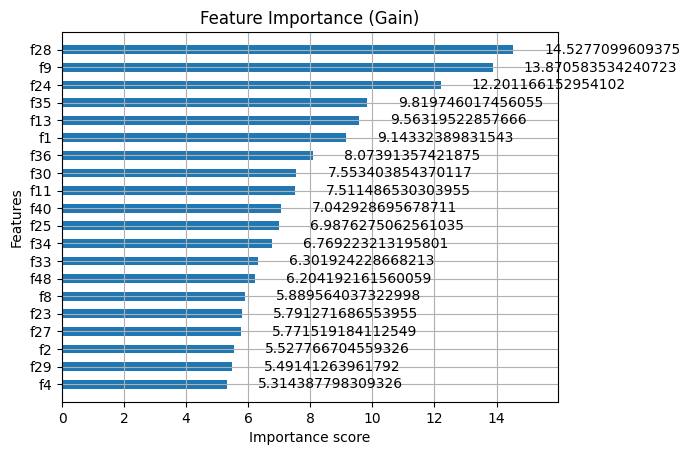

In [19]:
# Show feature importance
xgb.plot_importance(models["XGBoost"], importance_type='gain', max_num_features=20, height=0.5)
plt.title("Feature Importance (Gain)")
plt.show()

In [15]:
import numpy as np
import pandas as pd

# Assuming encoder, categorical_features, numerical_features, and logreg_model are already defined

# Get encoded categorical feature names
encoded_cat_features = encoder.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([encoded_cat_features, numerical_features])

# Get coefficients from logistic regression
coefficients = logreg_model.coef_[0]

# Create a Series with feature names and their coefficient values
feat_imp = pd.Series(coefficients, index=all_feature_names)

# Sort by absolute importance descending
feat_imp_sorted = feat_imp.reindex(feat_imp.abs().sort_values(ascending=False).index)

# Generate text summary
text_summary = []
for feature, coef in feat_imp_sorted.items():
    direction = "increases" if coef > 0 else "decreases"
    importance = abs(coef)
    text_summary.append(f"Feature '{feature}' has a coefficient of {coef:.4f} ({importance:.4f}), which {direction} the likelihood of being a risk taker.")

# Join all feature explanations
feature_importance_text = "\n".join(text_summary)

print(feature_importance_text)


Feature 'saving_frequency_Rarely' has a coefficient of -0.0956 (0.0956), which decreases the likelihood of being a risk taker.
Feature 'age_bucket_25-34' has a coefficient of 0.0794 (0.0794), which increases the likelihood of being a risk taker.
Feature 'payment_history_Excellent' has a coefficient of -0.0766 (0.0766), which decreases the likelihood of being a risk taker.
Feature 'saving_frequency_Monthly' has a coefficient of 0.0710 (0.0710), which increases the likelihood of being a risk taker.
Feature 'income_bucket_50,000–70,000' has a coefficient of -0.0653 (0.0653), which decreases the likelihood of being a risk taker.
Feature 'has_insurance_No' has a coefficient of -0.0635 (0.0635), which decreases the likelihood of being a risk taker.
Feature 'financial_goal_Travel' has a coefficient of -0.0597 (0.0597), which decreases the likelihood of being a risk taker.
Feature 'income_bucket_>70,000' has a coefficient of 0.0562 (0.0562), which increases the likelihood of being a risk taker

In [16]:
import numpy as np

# Assume df is your original DataFrame

# Calculate medians
credit_score_median = df['credit_score'].median()
job_tenure_median = df['job_tenure'].median()
dti_median = df['debt_to_income_ratio'].median()

# Define ranges around medians
credit_score_range = (credit_score_median - 50, credit_score_median + 50)
job_tenure_range = (job_tenure_median - 2, job_tenure_median + 2)
dti_range = (dti_median - 0.05, dti_median + 0.05)

# Create random default values within those ranges
default_values = {
    'credit_score': int(np.random.uniform(*credit_score_range)),
    'job_tenure': round(np.random.uniform(*job_tenure_range), 1),
    'debt_to_income_ratio': round(np.random.uniform(*dti_range), 2),
    'loan_purpose': 'Personal',  # or use df['loan_purpose'].mode()[0]
    'payment_history': 'Good'    # or use df['payment_history'].mode()[0]
}

print(default_values)


{'credit_score': 705, 'job_tenure': 8.4, 'debt_to_income_ratio': 0.35, 'loan_purpose': 'Personal', 'payment_history': 'Good'}


In [18]:
import pickle
import os

# Assuming you already have these variables loaded/trained:
# lr_model = your trained LogisticRegression model
# encoder = your trained OneHotEncoder or similar
# scaler = your trained StandardScaler or MinMaxScaler

# Calculate medians
credit_score_median = df['credit_score'].median()
job_tenure_median = df['job_tenure'].median()
dti_median = df['debt_to_income_ratio'].median()

# Define ranges around medians
credit_score_range = (credit_score_median - 50, credit_score_median + 50)
job_tenure_range = (job_tenure_median - 2, job_tenure_median + 2)
dti_range = (dti_median - 0.05, dti_median + 0.05)

complete_pipeline = {
    'model': logreg_model,
    'encoder': encoder,
    'scaler': scaler,
    'categorical_features': [
        'age_bucket', 'income_bucket', 'gender', 'occupation', 'education_level',
        'marital_status', 'loan_purpose', 'payment_history', 'financial_knowledge_level',
        'saving_frequency', 'investment_frequency', 'has_insurance', 'financial_goal', 'time_horizon'
    ],
    'numerical_features': [
        'credit_score', 'job_tenure', 'number_of_dependents', 'debt_to_income_ratio'
    ],
    'default_values': {
    'credit_score': int(np.random.uniform(*credit_score_range)),
    'debt_to_income_ratio': round(np.random.uniform(*dti_range), 2),
    'loan_purpose': df['loan_purpose'].mode()[0],
    'payment_history': df['payment_history'].mode()[0]
        }
}

# Save to pickle
desktop_path = r"C:\Users\manod\Desktop\Capstone\MyModels"  # No trailing backslash
file_path = os.path.join(desktop_path, "logistic_regression_model.pkl")

lr_model = models["Logistic Regression"]

with open(file_path, 'wb') as file:
    pickle.dump(lr_model, file)

print(f"Model saved to: {file_path}")


Model saved to: C:\Users\manod\Desktop\Capstone\MyModels\logistic_regression_model.pkl


Survey Data

In [22]:
# Survey Data Preprocessing
survey_df = pd.read_csv(r"C:\Users\manod\Desktop\Capstone\Data\Survey Data.csv")

In [23]:
survey_df.head()

,age,gender,income,occupation,education_level,marital_status,has_children,saving_frequency,investment_frequency,has_insurance,financial_goal,time_horizon,reaction_to_loss,risk_preference,financial_knowledge_level,risk_profile
0,25-34,Woman,"Less than €30,000",Student,Master,Married,No,Rarely,Never,Yes,General wealth building,More than 10 years,Hold and wait it out,I want a balance of safety and growth,Beginner,NaN
1,25-34,Man,"€30,000–€50,000",Salaried,Master,Single,No,Monthly,Regularly,Yes,General wealth building,More than 10 years,Invest more while prices are low,I want a balance of safety and growth,Intermediate,NaN
2,35-44,Man,"€30,000–€50,000",Self-Employed,Master,Married,No,Monthly,Regularly,Yes,Retirement,More than 10 years,Invest more while prices are low,I'm comfortable taking risks for potentially h...,Advanced,NaN
3,35-44,Woman,"€50,000–€70,000",Self-Employed,Bachelor,Single,No,Weekly,Regularly,Yes,Retirement,More than 10 years,Hold and wait it out,I want a balance of safety and growth,Beginner,NaN
4,55-65,Man,"More than €70,000",Salaried,Doctorate,Single,No,Weekly,Regularly,Yes,General wealth building,3 - 10 years,Invest more while prices are low,I'm comfortable taking risks for potentially h...,Advanced,NaN


In [24]:
import pandas as pd
import numpy as np


# --- 1. Rename Columns for Consistency ---
# Mapping from survey_df names to training data names
column_rename_mapping = {
    'age': 'age_bucket',
    'income': 'income_bucket',
    'has_children': 'number_of_dependents' # Renaming for consistency with training features
}
survey_df = survey_df.rename(columns=column_rename_mapping)

# --- 2. Transform 'income_bucket' values ---
# Mapping the specific income strings to a simpler format
income_mapping = {
    'Less than €30,000': '<30,000',
    '€30,000–€50,000': '30,000-50,000',
    '€50,000–€70,000': '50,000-70,000',
    'More than €70,000': '>70,000'
}
survey_df['income_bucket'] = survey_df['income_bucket'].replace(income_mapping)

# --- 3. Transform 'number_of_dependents' ('has_children') values ---
# Converting 'Yes'/'No' to 1/0. This is a simplification.
# If your training 'number_of_dependents' was a true count (e.g., 0, 1, 2, 3+),
# you might need a more sophisticated mapping or direct imputation for the count.
# Fill missing values first (e.g., assume no children if missing)
survey_df['number_of_dependents'] = survey_df['number_of_dependents'].map({'No': 0, 'Yes': 1})
survey_df['number_of_dependents'].fillna(0, inplace=True)  # or use the mode
survey_df['number_of_dependents'] = survey_df['number_of_dependents'].astype(int)


# --- 4. Add Missing Columns with NaNs ---
# List of columns expected by the trained model but missing in survey_df
missing_model_features = [
    'has_loan', 'credit_score', 'job_tenure', 'loan_purpose',
    'payment_history', 'debt_to_income_ratio'
]

for col in missing_model_features:
    if col not in survey_df.columns:
        survey_df[col] = np.nan # Add missing columns with NaN values

# --- 5. Impute Missing Values ---
# Placeholder values - YOU MUST REPLACE THESE WITH ACTUAL VALUES FROM YOUR TRAINING DATA!

# Numerical Imputation (e.g., median from training data)
# Replace with actual median from your training data's credit_score
impute_credit_score_median = df.credit_score.median()
# Replace with actual median from your training data's job_tenure
impute_job_tenure_median = df.job_tenure.median()
# Replace with actual median from your training data's debt_to_income_ratio
impute_debt_to_income_ratio_median = df.debt_to_income_ratio.median()

survey_df['credit_score'].fillna(impute_credit_score_median, inplace=True)
survey_df['job_tenure'].fillna(impute_job_tenure_median, inplace=True)
survey_df['debt_to_income_ratio'].fillna(impute_debt_to_income_ratio_median, inplace=True)

# Categorical Imputation (e.g., mode from training data)
# Replace with actual mode from your training data's has_loan
impute_has_loan_mode = '0'
# Replace with actual mode from your training data's loan_purpose
impute_loan_purpose_mode = 'Personal'
# Replace with actual mode from your training data's payment_history
impute_payment_history_mode = 'Good'

survey_df['has_loan'].fillna(impute_has_loan_mode, inplace=True)
survey_df['loan_purpose'].fillna(impute_loan_purpose_mode, inplace=True)
survey_df['payment_history'].fillna(impute_payment_history_mode, inplace=True)


print("\nSurvey Data after Renaming and Imputation - Head:")
print(survey_df.head())
print("\nSurvey Data after Renaming and Imputation - Info (check for NaNs):")


Survey Data after Renaming and Imputation - Head:
  age_bucket gender  income_bucket     occupation education_level  \
0      25-34  Woman        <30,000        Student          Master   
1      25-34    Man  30,000-50,000       Salaried          Master   
2      35-44    Man  30,000-50,000  Self-Employed          Master   
3      35-44  Woman  50,000-70,000  Self-Employed        Bachelor   
4      55-65    Man        >70,000       Salaried       Doctorate   

  marital_status  number_of_dependents saving_frequency investment_frequency  \
0        Married                     0           Rarely                Never   
1         Single                     0          Monthly            Regularly   
2        Married                     0          Monthly            Regularly   
3         Single                     0           Weekly            Regularly   
4         Single                     0           Weekly            Regularly   

  has_insurance  ...                  reaction_to_los

In [25]:
#Changing the type of columns to the most appropriate ones
#Convert appropriate columns to categorical
categorical_cols = ['gender', 'occupation', 'education_level', 'marital_status', 'loan_purpose','payment_history','financial_knowledge_level']
for col in categorical_cols:
    survey_df [col] = survey_df[col].astype('category')			

In [26]:
import numpy as np

# Define features used in the model (exclude 'reaction_to_loss')
categorical_features = [
    'age_bucket', 'income_bucket', 'gender', 'occupation', 'education_level',
    'marital_status', 'loan_purpose', 'payment_history', 'financial_knowledge_level',
    'saving_frequency', 'investment_frequency', 'has_insurance', 'financial_goal', 'time_horizon'
]
numerical_features = ['credit_score', 'job_tenure', 'number_of_dependents', 'debt_to_income_ratio']

all_features = categorical_features + numerical_features

# Copy survey_df so original is untouched
survey_df_model = survey_df.copy()

# Drop any columns not used in model
for col in survey_df_model.columns:
    if col not in all_features:
        survey_df_model.drop(columns=col, inplace=True)

# Add missing columns with NaN if any model feature is missing
for col in all_features:
    if col not in survey_df_model.columns:
        survey_df_model[col] = np.nan  # or fill with appropriate value if preferred

# Reorder columns to match model
survey_df_model = survey_df_model[categorical_features + numerical_features]

# Convert categorical columns to 'category' dtype
for col in categorical_features:
    survey_df_model[col] = survey_df_model[col].astype('category')

# Encode categorical columns
X_survey_cat = encoder.transform(survey_df_model[categorical_features])

# Scale numerical columns
X_survey_num = scaler.transform(survey_df_model[numerical_features])

# Combine encoded categorical and scaled numerical features
X_survey_processed = np.hstack([X_survey_cat, X_survey_num])


In [29]:
# Predict classes (0 = Low Risk, 1 = Risk Taker)
survey_predictions = models["KNN"].predict(X_survey_processed)

# Predict probabilities ([:, 1] gives the prob of class 1 = 'Risk Taker')
survey_probs = models["KNN"].predict_proba(X_survey_processed)[:, 1]

print("Predicted classes on survey data:")
print(survey_predictions)

print("Predicted probabilities of being 'Risk Taker':")
print(survey_probs)


Predicted classes on survey data:
[0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 1 0 1 0 0 1 0 0 1 1 1 1
 1 1 1 0 0 0 1 1 0 1]
Predicted probabilities of being 'Risk Taker':
[0.4 1.  0.6 0.  0.6 0.6 0.6 0.6 0.6 0.6 0.8 0.8 0.6 0.4 0.2 0.2 0.8 0.4
 0.8 0.4 0.6 0.6 0.8 0.8 0.4 0.6 0.2 0.6 0.4 0.2 0.6 0.2 0.4 0.6 0.6 0.8
 0.6 0.8 0.6 0.8 0.  0.4 0.2 0.6 0.8 0.2 0.6]


In [ ]:
# 1. Preprocess new data
new_cat = encoder.transform(new_df[categorical_features])
new_num = scaler.transform(new_df[numerical_features])

# 2. Combine encoded categorical + scaled numerical
new_data = np.hstack([new_cat, new_num])

# 3. Predict class (0 or 1)
predicted_class = xgb_model.predict(new_data)

# 4. Predict probability (e.g., for risk confidence)
predicted_proba = xgb_model.predict_proba(new_data)

# Show results
for i in range(len(new_df)):
    print(f"Input #{i+1}")
    print(f"Predicted class: {predicted_class[i]}")
    print(f"Probability (Risk Taker): {predicted_proba[i][1]:.2f}")
    print(f"Probability (Low Risk): {predicted_proba[i][0]:.2f}")
    print("-" * 30)


In [30]:
survey_df['risk_rating'] = survey_predictions

# Save the updated DataFrame
survey_df.to_csv(r"C:\Users\manod\Desktop\Capstone\Data\survey_with_risk_rating.csv", index=False)

print("Exported survey data with predictions to 'survey_with_risk_rating.csv'")

Exported survey data with predictions to 'survey_with_risk_rating.csv'
